In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lrp import lrp_engine, checkpoint_hook
# from lrp_graph import make_graph

In [4]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
          (wo): L

In [6]:
for layer_module in model.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [21]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGCGGGATTAGAGTAG"
inputs = torch.tensor([[   1,  240,  350,  156,  846,  224, 2425,  407, 2950,   96, 2094,  151,
          781,   90,  202,  111,  137,   47, 1088,  118,   25,  333,   40,  216,
          169,   35,  219,  528,  247,   39,   31,  267,  449,   34,  159,  658,
          992,   61,  388,  169,   29,  200,   13, 1317,  553,  160,   93, 3271,
           33,  139,   36,  563,   40,  745,   34,  280,   23,  194,   32,  661,
          461, 2713,   30,  841, 1122,  166,   15,  168,  194,  114,   61, 2556,
          136,   41,  158,   72,  201,  455,   34,  385,   15,  707,  476,  173,
          651,  181,  710,  246,  288,   35,  254, 2787,  128,  228,  106,   93,
          833,  231,   13, 2329, 1078,  194,   52,   19,  483,   52,   90,  407,
          124,   13,  138,   13,    2]])
#tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states : torch.Tensor = model(inputs.to(device), requires_grad=True)[0] # [1, sequence_length, 768]

In [22]:
# checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half())
checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half())

tensor(nan, device='cuda:0')


In [23]:
checkpoint_vals

[tensor([[ 1.9677e-09,  7.8023e-08,  3.2418e-08,  ..., -3.9459e-09,
           1.5400e-08, -9.4325e-09],
         [ 7.9566e-08,  3.5088e-07,  4.8064e-06,  ..., -1.6757e-08,
          -5.7495e-07, -2.1403e-08],
         [ 5.8306e-08, -2.0177e-06,  3.2115e-06,  ..., -1.7676e-06,
          -2.3486e-07, -3.8669e-07],
         ...,
         [-5.4841e-07, -5.6260e-09, -2.3354e-06,  ..., -1.4491e-07,
           1.2429e-07, -1.3331e-07],
         [ 1.7156e-06,  4.6155e-08, -4.9489e-06,  ..., -5.7714e-07,
          -1.5200e-07,  5.2039e-07],
         [ 1.0104e-07,  9.2320e-08, -2.2527e-06,  ..., -2.6546e-09,
           7.6086e-09, -7.2363e-09]], device='cuda:0'),
 tensor([[ 1.0689e-07,  2.8523e-08,  1.2689e-08,  ..., -3.0822e-08,
           3.2691e-08, -4.4411e-09],
         [-1.5535e-06,  5.1196e-07, -8.2249e-07,  ..., -7.7773e-06,
           3.4965e-06,  4.1621e-08],
         [ 1.5098e-07,  3.4555e-07,  1.1363e-05,  ...,  8.6425e-06,
           1.4840e-06,  4.3946e-08],
         ...,
        

In [24]:
checkpoint_vals1, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)
# input_frontier, child, res, node_ind, ind_to_node = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)
# ind_to_node = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)

In [9]:
from promise import Promise
# visited = sorted(list(visited1), key=lambda x: x._sequence_nr())
# visited_map = { str(node) : node for node in visited }
promises = Promise.all_promises

In [18]:
non_matching_proms = [ p for p in promises
                      if p.other_branch is not None
                      and p.other_branch.complete
                      and isinstance(p.arg, torch.Tensor) == isinstance(p.other_branch.arg, torch.Tensor)
                      and isinstance(p.rin, torch.Tensor) == isinstance(p.other_branch.rin, torch.Tensor)
                      and (p.arg.shape != p.other_branch.arg.shape
                           or p.rin.shape != p.other_branch.rin.shape) ]
non_matching_parents = [ p for p in promises
                        if (p.children
                            and any(any(p.rin.shape != elem.rout.shape for elem in c) if isinstance(c, tuple) else p.rin.shape != c.rout.shape for c in p.children))
                        or (p.parents
                            and any(p.rout.shape != par.rin.shape for par in p.parents))
                       ]

NameError: name 'promises' is not defined

In [14]:
[ (p.start_ind, p.arg_node_ind) for p in non_matching_parents ]

[(95, 94), (45, 43), (94, 34), (94, 93)]

In [25]:
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals, checkpoint_vals1)
]

[tensor(5.4953e-12, device='cuda:0'),
 tensor(9.7267e-13, device='cuda:0'),
 tensor(4.7102e-13, device='cuda:0'),
 tensor(4.5855e-13, device='cuda:0'),
 tensor(1.9636e-13, device='cuda:0'),
 tensor(2.0584e-13, device='cuda:0'),
 tensor(1.0391e-12, device='cuda:0'),
 tensor(2.3682e-12, device='cuda:0'),
 tensor(3.1872e-12, device='cuda:0'),
 tensor(1.2625e-11, device='cuda:0'),
 tensor(1.0036e-10, device='cuda:0'),
 tensor(nan, device='cuda:0')]

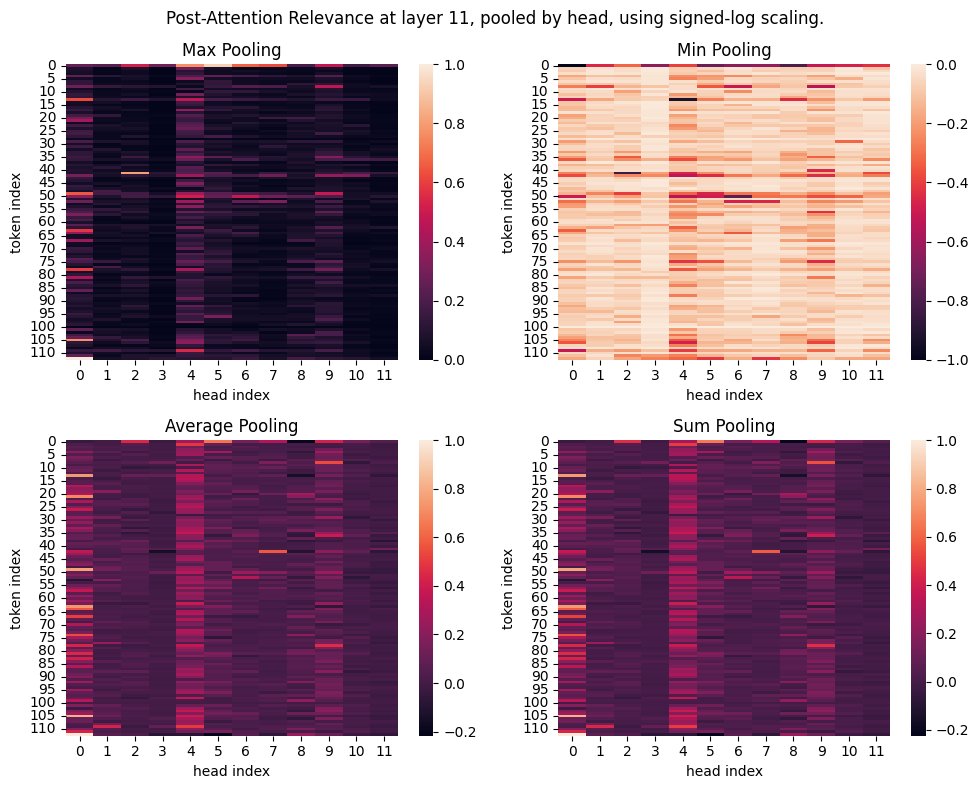

In [33]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 11

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(checkpoint_vals[layer_ind], 0))
    lrp_shape = checkpoint_output.shape
    raw_heatmap = checkpoint_output.view((lrp_shape[-2], lrp_shape[-1])).nan_to_num(0.0)
    normed = raw_heatmap.sign() * torch.log1p(raw_heatmap.abs())
    normed /= torch.max(normed.abs())
    sns.heatmap(normed.cpu(), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2 - 1:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head, using signed-log scaling.")
fig.tight_layout()

plt.show()

In [11]:
# For debugging relevance paths

# import networkx as nx
# import matplotlib.pyplot as plt

# node_to_ind = { node : i for (i, node) in enumerate(nodes) }
# def create_graph(nodes, in_adj_list, weights, alpha = 0.5):    
#     G = nx.DiGraph()
#     G.add_nodes_from(range(len(nodes)))

#     print(node_to_ind[start], node_to_ind[end]) # Global vars, set somewhere

#     for node, in_nodes in list(in_adj_list.items()):
#         if node not in nodes:
#             continue
#         for in_node, in_weight in zip(in_nodes, input_tracker[node]):
#             if in_node not in nodes:
#                 continue
#             if isinstance(in_weight, AddBackwardPromise):
#                 if in_weight.complete:
#                     in_weight = in_weight.rin.sum()
#                 else:
#                     continue
#             elif isinstance(in_weight, torch.Tensor):
#                 in_weight = in_weight.sum()
#             G.add_edge(node_to_ind[in_node], node_to_ind[node], weight=float(in_weight))
#     return G

# def display_graph(G):
#     pos = nx.circular_layout(G)  
#     weight_labels = nx.get_edge_attributes(G, 'weight')
#     plt.figure(figsize=(50,50))
#     nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=100)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)  
#     plt.show()

# G = create_graph(nodes, in_adj_list, input_tracker)

# print([ x for x in dir(nx) if x.endswith("layout") ])
# display_graph(G)
# print(nx.get_edge_attributes(G, 'weight'))


In [12]:
# Check that promises maintain conservation property
complete = list(filter(lambda p: p.complete, promises))
for p in complete:
    rout = p.promise["rout"].sum()
    rin = p.promise["rins"][0].sum() + p.promise["rins"][1].sum()
    if (rout - rin) / rout > 0.00001:
        print(rout, rin)
        

In [13]:
# Checking conservation holds across the entire propagation
# The frontier includes:
# a) true leaf nodes (no children)
# b) nodes which received inputs but were never traversed due to computation ending early

frontier = [ node 
            for node, out_nodes in list(out_adj_list.items())
            if len(out_nodes) == 0
           ]

frontier += [ node for node in stack if input_tracker[node] ]

frontier = list(set(frontier))

In [14]:
# Tally the total relevance at the frontier
total_frontier_in = 0.0
for node in frontier:
    total_in = 0.0
    for input_ in input_tracker[node]:
        if isinstance(input_, AddBackwardPromise):
            if input_.complete:
                total_in += input_.rin.sum()
            else:
                continue
        elif isinstance(input_, torch.Tensor):
            total_in += input_.sum()
    total_frontier_in += total_in
print(total_frontier_in)

tensor(17.0376)


In [85]:
list(enumerate(visited))

[(0, <NativeLayerNormBackward0 at 0x21cd31ebee0>),
 (1, <ViewBackward0 at 0x21cd31eb790>),
 (2, <torch.autograd.function.IndexFirstAxisBackward at 0x21b051738a0>),
 (3, <torch.autograd.function.LRPCheckpointBackward at 0x21cd31679b0>),
 (4, <util.MmBackward0 at 0x21cced12050>),
 (5, <util.AddBackward0 at 0x21cced13950>),
 (6, <AddBackward0 at 0x21cd31e8fa0>),
 (7, <NativeLayerNormBackward0 at 0x21cd31eb3d0>),
 (8, <MmBackward0 at 0x21cd31ef250>),
 (9, <SliceBackward0 at 0x21cd31ef010>),
 (10, <SliceBackward0 at 0x21cd31ebfa0>),
 (11, <SliceBackward0 at 0x21cd31ebf10>),
 (12, <SliceBackward0 at 0x21cd31eb9d0>),
 (13, <GeluBackward0 at 0x21cd31eb8b0>),
 (14, <MulBackward0 at 0x21cd31e8e80>),
 (15, <util.AddBackward0 at 0x21cced16050>),
 (16, <util.MmBackward0 at 0x21cced16210>),
 (17, <AddBackward0 at 0x21cd31e8880>),
 (18, <NativeLayerNormBackward0 at 0x21cd31e89d0>),
 (19, <util.AddBackward0 at 0x21ccc62abd0>),
 (20, <util.MmBackward0 at 0x21ccc62bd10>),
 (21, <torch.autograd.function.